# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 8: Review Trees and Boosting including Ada Boosting Gradient Boosting and XGBoost.

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

This section will work with a spam email dataset again. Our ultimate goal is to be able to build models so that we can predict whether an email is spam or not spam based on word characteristics within each email. We will review Decision Trees, Bagging, and Random Forest methods, and introduce Boosting: Ada Boost and XGBoost.

Specifically, we will: 
  
1. *Quick review of last week*  
2. Rebuild the Decision Tree model, Bagging model, Random Forest Model just for comparison with Boosting. 
3. *Theory:* What is Boosting?
4. Use the Adaboost on the Spam Dataset.
5. *Theory:* What is Gradient Boosting and XGBoost?
6. Use XGBoost on the Spam Dataset: Extreme Gradient Boosting

Optional: Example to better understand Bias vs Variance tradeoff.

---------
## 1. *Quick review of last week*  

#### The Idea: Decision Trees are just flowcharts and interpretable!

It turns out that simple flow charts can be formulated as mathematical models for classification and these models have the properties we desire;
 - interpretable by humans 
 - have sufficiently complex decision boundaries 
 - the decision boundaries are locally linear, each component of the decision boundary is simple to describe mathematically. 

----------

#### How to build Decision Trees (the Learning Algorithm in words): 
To learn a decision tree model, we take a greedy approach: 
 1. Start with an empty decision tree (undivided feature space) 
 2. Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting by applying a **splitting criterion (1)**
 3. Recurse on on each new node until **stopping condition (2)** is met

#### So we need a (1) splitting criterion and a (2) stopping condition:

  #### (1) Splitting criterion 

<img src="data/split2_adj.png" alt="split2" width="70%"/>

#### (2) Stopping condition

**Not stopping while building a deeper and deeper tree = 100% training accuracy; Yet we will overfit! 

To prevent the **overfitting** from happening, we should have stopping condition.

-------------

#### How do we go from Classification to Regression?

- For classification, we return the majority class in the points of each leaf node. 
- For regression we return the average of the outputs for the points in each leaf node. 

-------------

#### What is bagging?
  
One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results. 

 1. **Bootstrap:** we generate multiple samples of training data, via bootstrapping. We train a full decision tree on each sample of data. 
 2. **AGgregatiING** for a given input, we output the averaged outputs of all the models for that input. 
 
This method is called **Bagging: B** ootstrap + **AGG**regat**ING**. 

-------------

#### What is Random Forest? 

- **Many trees** make a **forest**.
- **Many random trees** make a **random forest**.


Random Forest is a modified form of bagging that creates ensembles of independent decision trees. 
To *de-correlate the trees*, we: 
1. train each tree on a separate bootstrap **random sample** of the full training set (same as in bagging) 
2. for each tree, at each split, we **randomly select a set of 𝐽′ predictors from the full set of predictors.** (not done in bagging)
3. From amongst the 𝐽′  predictors, we select the optimal predictor and the optimal corresponding threshold for the split. 


-------------

#### Interesting Piazza post: why randomness in simple decision tree?
 
 ```"Hi there. I notice that there is a parameter called "random_state" in decision tree function and I wonder why we need randomness in simple decision tree. If we add randomness in such case, isn't it the same as random forest?"```
 
  - The problem of learning an optimal decision tree is known to be **NP-complete** under several aspects of optimality and even for simple concepts. 
  - Consequently, practical decision-tree learning algorithms are based on **heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node**. 
  - Such algorithms **cannot guarantee to return the globally optimal decision tree**. 
  - This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement (Bagging).
  
For example: **What is the defaulth DecisionTreeClassifier behaviour when there are 2 or more best features for a certain split (a tie among "splitters")?** (after a deep dive and internet search [link](https://github.com/scikit-learn/scikit-learn/issues/12259 ) ):

  - The current default behaviour when splitter="best" is to shuffle the features at each step and take the best feature to split. 
  - In case there is a tie, we take a random one.


-------------

## 2. Just re-building the tree models of last week

### Rebuild the Decision Tree model, Bagging model and Random Forest Model for comparison with Boosting methods

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Spam` that indicates whether an email is spam or not spam. **The goal is to be able to create a classifier or method that acts as a spam filter.**

Link to description : https://archive.ics.uci.edu/ml/datasets/spambase

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn.metrics as metrics
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve

In [3]:
#Import Dataframe and Set Column Names
spam_df = pd.read_csv('data/spam.csv', header=None)
columns = ["Column_"+str(i+1) for i in range(spam_df.shape[1]-1)] + ['Spam']
spam_df.columns = columns
display(spam_df.head())

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33,Column_34,Column_35,Column_36,Column_37,Column_38,Column_39,Column_40,Column_41,Column_42,Column_43,Column_44,Column_45,Column_46,Column_47,Column_48,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
#Let us split the dataset into a 70-30 split by using the following:
#Split data into train and test
np.random.seed(42)
msk = np.random.rand(len(spam_df)) < 0.7
data_train = spam_df[msk]
data_test = spam_df[~msk]

#Split predictor and response columns
x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

print("Shape of Training Set :",data_train.shape)
print("Shape of Testing Set :" ,data_test.shape)

Shape of Training Set : (3262, 58)
Shape of Testing Set : (1339, 58)


In [5]:
#Check Percentage of Spam in Train and Test Set
percentage_spam_training = 100*y_train.sum()/len(y_train)
percentage_spam_testing  = 100*y_test.sum()/len(y_test)
                                                  
print("Percentage of Spam in Training Set \t : {:0.2f}%.".format(percentage_spam_training))
print("Percentage of Spam in Testing Set \t : {:0.2f}%.".format(percentage_spam_testing))

Percentage of Spam in Training Set 	 : 39.18%.
Percentage of Spam in Testing Set 	 : 39.96%.


-----------

### Fitting an Optimal Single Decision Tree

In [6]:
# Best depth for single decision trees of last week
best_depth = 7
print("The best depth was found to be:", best_depth)

The best depth was found to be: 7


In [7]:
#Evalaute the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(x_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set
acc_trees_training = accuracy_score(y_train, model_tree.predict(x_train))
acc_trees_testing  = accuracy_score(y_test,  model_tree.predict(x_test))

print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

Simple Decision Trees: Accuracy, Training Set 	 : 94.39%
Simple Decision Trees: Accuracy, Testing Set 	 : 90.81%



--------

### Fitting 100 Single Decision Trees while Bagging


In [8]:
n_trees = 100 # we tried a variety of numbers here

#Creating model
np.random.seed(0)
model = DecisionTreeClassifier(max_depth=best_depth+5)

#Initializing variables
predictions_train = np.zeros((data_train.shape[0], n_trees))
predictions_test = np.zeros((data_test.shape[0], n_trees))

#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    response_variable = temp['Spam']
    temp = temp.drop(['Spam'], axis=1)
    
    model.fit(temp, response_variable)  
    predictions_train[:,i] = model.predict(x_train)   
    predictions_test[:,i] = model.predict(x_test)
    
#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)

In [9]:
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train, count=-1))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test, count=-1))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

Bagging: 	Accuracy, Training Set 	: 97.70%
Bagging: 	Accuracy, Testing Set 	: 93.35%


### Fitting Random Forest

In [10]:
#Fit a Random Forest Model
#Training
model = RandomForestClassifier(n_estimators=n_trees, max_depth=best_depth+5)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Performance Evaluation
acc_random_forest_training = accuracy_score(y_train, y_pred_train)*100
acc_random_forest_testing = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(acc_random_forest_testing))

Random Forest: Accuracy, Training Set : 98.10%
Random Forest: Accuracy, Testing Set :  94.77%


#### Let's compare the performance of our 3 models:

In [11]:
print("Decision Trees:\tAccuracy, Training Set \t: {:.2%}".format(acc_trees_training))
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))

print("\nBagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

print("\nRandom Forest: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))

Decision Trees:	Accuracy, Training Set 	: 94.39%
Decision Trees:	Accuracy, Testing Set 	: 90.81%

Bagging: 	Accuracy, Training Set 	: 97.70%
Bagging: 	Accuracy, Testing Set 	: 93.35%

Random Forest: 	Accuracy, Training Set 	: 98.10%
Random Forest: 	Accuracy, Testing Set 	: 94.77%


## 3. *Theory:* What is Boosting?

- **Bagging and Random Forest:**
  - complex and deep trees **overfit**
  - thus **let's perform variance reduction on complex trees!**
- **Boosting:** 
  - simple and shallow trees **underfit** 
  - thus **let's perform bias reduction of simple trees!**
  - make the simple trees more expressive!
  
**Boosting** attempts to improve the predictive flexibility of simple models.
 - It trains a **large number of “weak” learners in sequence**.
 - A weak learner is a constrained model (limit the max depth of each decision tree).
 - Each one in the sequence focuses on **learning from the mistakes** of the one before it.
 - By more heavily weighting in the mistakes in the next tree, our next tree will learn from the mistakes.
 - A combining all the weak learners into a single strong learner = **a boosted tree**.

<img src="data/gradient_boosting1.png?" alt="tree_adj" width="70%"/>

----------

### Illustrative example (from [source](https://towardsdatascience.com/underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6fe4a8a49dbf))

<img src="data/boosting.png" alt="tree_adj" width="70%"/>

We built multiple trees consecutively: Tree 1 -> Tree 2 -> Tree 3 - > ....

**The size of the plus or minus singns indicates the weights of a data points for every Tree**. How do we determine these weights?

For each consecutive tree and iteration we do the following:
 - The **wrongly classified data points ("mistakes" = red circles)** are identified and **more heavily weighted in the next tree (green arrow)**. 
 - Thus the size of the plus or minus changes in the next tree
 - This change in weights will influence and change the next simple decision tree
 - The **correct predictions are** identified and **less heavily weighted in the next tree**.

We iterate this process for a certain number of times, stop and construct our final model: 
- The ensemble (**"Final: Combination"**) is a linear combination of the simple trees, and is more expressive!
- The ensemble (**"Final: Combination"**) has indeed not just one simple decision boundary line, and fits the data better.
 
 
<img src="data/boosting_2.png?" alt="tree_adj" width="70%"/>

### What is Ada Boost?

- Ada Boost = Adaptive Boosting.
- AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers

<img src="data/AdaBoost1.png" alt="tree_adj" width="70%"/>
<img src="data/AdaBoost2.png" alt="tree_adj" width="70%"/>
<img src="data/AdaBoost3.png" alt="tree_adj" width="70%"/>

**Notice that when $\hat{y}_n = 𝑦_n$, the weight $w_n$ is small; when $\hat{y}_n \neq 𝑦_n$, the weight $w_n$ is larger.**

### Illustrative Example (from slides)
------
**Step1. Start with equal distribition initially**
<img src="data/ADA2.png" alt="tree_adj" width="40%">

------
**Step2. Fit a simple classifier**
<img src="data/ADA3.png" alt="tree_adj" width="40%"/>

------
**Step3. Update the weights**
<img src="data/ADA4.png" alt="tree_adj" width="40%"/>

**Step4. Update the classifier:** First time trivial (we have no model yet.)

------
**Step2. Fit a simple classifier**
<img src="data/ADA5.png" alt="tree_adj" width="40%"/>

**Step3. Update the weights:** not shown.

------
**Step4. Update the classifier:**
<img src="data/ADA6.png" alt="tree_adj" width="40%">


## 4. Use the Adaboost method to visualize Bias-Variance tradeoff.

Now let's try Boosting!

In [12]:
#Fit an Adaboost Model

#Training
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), 
                           n_estimators=200, 
                           learning_rate=0.05)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Performance Evaluation
acc_boosting_training = accuracy_score(y_train, y_pred_train)*100
acc_boosting_test = accuracy_score(y_test, y_pred_test)*100

print("Ada Boost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_boosting_training))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Ada Boost:	Accuracy, Training Set 	: 99.63%
Ada Boost:	Accuracy, Testing Set 	: 94.25%


**How does the test and training accuracy evolve with every iteration (tree)?**

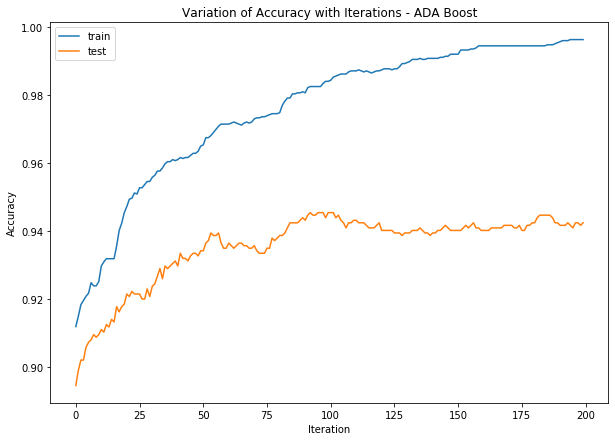

In [13]:
#Plot Iteration based score
train_scores = list(model.staged_score(x_train,y_train))
test_scores = list(model.staged_score(x_test, y_test))

plt.figure(figsize=(10,7))
plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations - ADA Boost")
plt.legend();

What about performance?

In [14]:
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Decision Trees:	Accuracy, Testing Set 	: 90.81%
Bagging: 	Accuracy, Testing Set 	: 93.35%
Random Forest: 	Accuracy, Testing Set 	: 94.77%
Ada Boost:	Accuracy, Testing Set 	: 94.25%


AdaBoost seems to be performing better than Simple Decision Trees and has a similar Test Set Accuracy performance compared to Random Forest.

**Random tip:** If a "for"-loop takes som time and you want to know the progress while running the loop, use: **tqdm()** ([link](https://github.com/tqdm/tqdm)). No need for 1000's of ```print(i)``` outputs.


Usage: ```for i in tqdm( range(start,finish) ):```

 - tqdm means *"progress"* in Arabic (taqadum, تقدّم) and 
 - tqdm is an abbreviation for *"I love you so much"* in Spanish (te quiero demasiado).

#### What if we change the depth of our AdaBoost trees?

In [15]:
# Start Timer
start = time.time()

#Find Optimal Depth of trees for Boosting
score_train, score_test, depth_start, depth_end = {}, {}, 2, 30
for i in tqdm(range(depth_start, depth_end, 2)):
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=i),
        n_estimators=200, learning_rate=0.05)
    model.fit(x_train, y_train)
    score_train[i] = accuracy_score(y_train, model.predict(x_train))
    score_test[i] = accuracy_score(y_test, model.predict(x_test))
    
# Stop Timer
end = time.time()
elapsed_adaboost = end - start

100%|██████████| 14/14 [00:52<00:00,  3.78s/it]


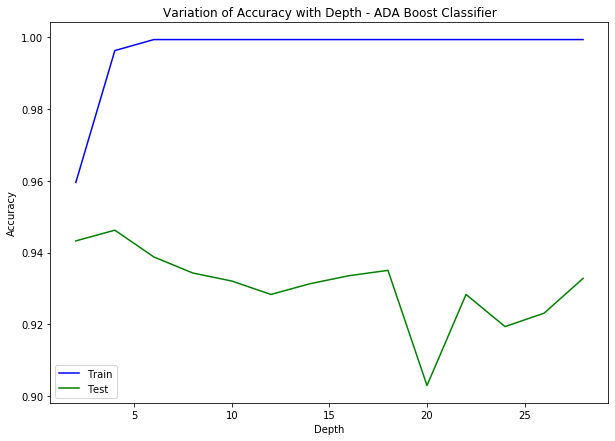

In [16]:
#Plot
lists1 = sorted(score_train.items())
lists2 = sorted(score_test.items())
x1, y1 = zip(*lists1) 
x2, y2 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title('Variation of Accuracy with Depth - ADA Boost Classifier')
plt.plot(x1, y1, 'b-', label='Train')
plt.plot(x2, y2, 'g-', label='Test')
plt.legend()
plt.show()

Adaboost complexity depends on both the number of estimators and the base estimator. 
- In the beginning as our model complexity increases (depth 2-3), we first observe a small increase in accuracy.
- But as we go further to the right of the graph (**deeper trees**), our model **will overfit the data.**
- **REMINDER and validation: Boosting relies on simple trees!**

**Food for Thought :**
- Are **boosted models independent of one another?** Do they need to wait for the previous model's residuals?
- Are **bagging or random forest models independent of each other**, can they be trained in a parallel fashion?

## 5. *Theory:* What is Gradient Boosting and XGBoost?

### What is Gradient Boosting?

To improve its predictions, **gradient boosting looks at the difference between its current approximation, and the known correct target vector, which is called the residual**.

The mathematics:

- It may be assumed that there is some imperfect model $F_{m}$ 
- The gradient boosting algorithm improves on $F_{m}$ constructing a new model that adds an estimator $h$ to provide a better model: 
$$F_{m+1}(x)=F_{m}(x)+h(x)$$

- To find $h$, the gradient boosting solution starts with the observation that a perfect **h** would imply

$$F_{m+1}(x)=F_{m}(x)+h(x)=y$$

- or, equivalently solving for h,

$$h(x)=y-F_{m}(x)$$

- Therefore, gradient boosting will fit h to the residual $y-F_{m}(x)$

<img src="data/gradient_boosting2.png" alt="tree_adj" width="80%"/>


-------

### XGBoost: ["Long May She Reign!"](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

<img src="data/kaggle.png" alt="tree_adj" width="100%"/>


----------

### What is XGBoost and why is it so good!?
 - Based on Gradient Boosting
 - XGBoost = **eXtreme Gradient Boosting**; refers to the engineering goal to push the limit of computations resources for boosted tree algorithm
 
**Accuracy:**
 - XGBoost however uses a **more regularized model formalizaiton to control overfitting** (=better performance) by both L1 and L2 regularization.
 - Tree Pruning methods: more shallow tree will also prevent overfitting
 - Improved convergence techniques (like early stopping when no improvement is made for X number of iterations)
 - Built-in Cross-Validaiton
 
**Computing Speed:**
 - Special Vector and matrix type data structures for faster results.
 - Parallelized tree building: using all of your CPU cores during training.
 - Distributed Computing: for training very large models using a cluster of machines.
 - Cache Optimization of data structures and algorithm: to make best use of hardware.

**XGBoost is building boosted trees in parallel? What? How?**
- No: Xgboost doesn't run multiple trees in parallel, you need predictions after each tree to update gradients.
- Rather it does the parallelization WITHIN a single tree my using openMP to create branches independently.

## 6. Use XGBoost: Extreme Gradient Boosting

In [17]:
# Let's install XGBoost
! pip install xgboost

     |████████████████████████████████| 686kB 3.0MB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-0.90-cp37-cp37m-macosx_10_9_x86_64.whl size=1710238 sha256=18e09806bd83261c667f7548a9214ad196204cdbc0034e2b567082461590c152
  Stored in directory: /Users/tamastolerian/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost


In [19]:
import xgboost as xgb

# Create the training and test data
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Parameters
param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,               # the training step for each iteration
    'silent': 1,              # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}           # the number of classes that exist in this datset

# Number of training iterations
num_round = 200  

# Start timer
start = time.time()

# Train XGBoost
bst = xgb.train(param, 
                dtrain, 
                num_round, 
                evals= [(dtrain, 'train')], 
                early_stopping_rounds=20, # early stopping
                verbose_eval=20)


# Make prediction training set
preds_train = bst.predict(dtrain)
best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

# Make prediction test set
preds_test = bst.predict(dtest)
best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

# Performance Evaluation 
acc_XGBoost_training = accuracy_score(y_train, best_preds_train)*100
acc_XGBoost_test = accuracy_score(y_test, best_preds_test)*100

# Stop Timer
end = time.time()
elapsed_xgboost = end - start

print("XGBoost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_XGBoost_training))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

[0]	train-merror:0.05794
Will train until train-merror hasn't improved in 20 rounds.
[20]	train-merror:0.014102
[40]	train-merror:0.005518
[60]	train-merror:0.001533
[80]	train-merror:0.000613
[100]	train-merror:0.000613
Stopping. Best iteration:
[80]	train-merror:0.000613

XGBoost:	Accuracy, Training Set 	: 99.94%
XGBoost:	Accuracy, Testing Set 	: 95.07%


### What about the accuracy performance: AdaBoost versus XGBoost?

In [20]:
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

Ada Boost:	Accuracy, Testing Set 	: 94.25%
XGBoost:	Accuracy, Testing Set 	: 95.07%


### What about the computing performance: AdaBoost versus XGBoost?

In [21]:
print("AdaBoost elapsed time: \t{:0.2f}s".format(elapsed_adaboost))
print("XGBoost elapsed time: \t{:0.2f}s".format(elapsed_xgboost))

AdaBoost elapsed time: 	52.98s
XGBoost elapsed time: 	2.28s


### What if we change the depth of our XGBoost trees and compare to Ada Boost?

In [22]:
def model_xgboost(best_depth):
    param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset

    # the number of training iterations
    num_round = 200  

    bst = xgb.train(param, 
                    dtrain, 
                    num_round, 
                    evals= [(dtrain, 'train')], 
                    early_stopping_rounds=20,
                    verbose_eval=False)

    preds_train = bst.predict(dtrain)
    best_preds_train = np.asarray([np.argmax(line) for line in preds_train])
    preds_test = bst.predict(dtest)
    best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

    #Performance Evaluation
    XGBoost_training = accuracy_score(y_train, best_preds_train)
    XGBoost_test = accuracy_score(y_test, best_preds_test)
    
    return XGBoost_training, XGBoost_test

In [23]:
#Find Optimal Depth of trees for Boosting
score_train_xgb, score_test_xgb = {}, {}
depth_start, depth_end = 2, 30
for i in tqdm(range(depth_start, depth_end, 2)):
    XGBoost_training, XGBoost_test = model_xgboost(i)
    score_train_xgb[i] = XGBoost_training
    score_test_xgb[i] = XGBoost_test

100%|██████████| 14/14 [00:25<00:00,  1.81s/it]


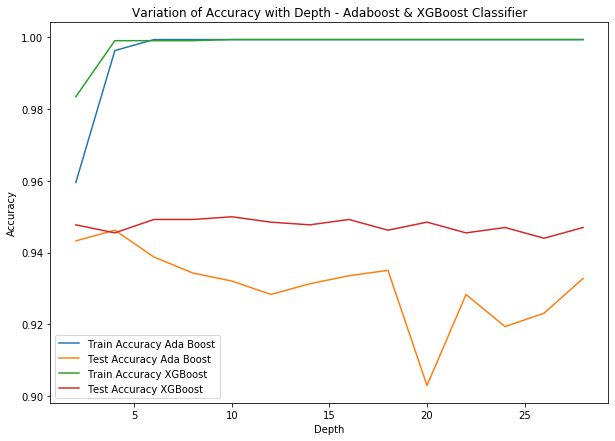

In [24]:
#Plot
lists1 = sorted(score_train_xgb.items())
lists2 = sorted(score_test_xgb.items())
x3, y3 = zip(*lists1) 
x4, y4 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title('Variation of Accuracy with Depth - Adaboost & XGBoost Classifier')
plt.plot(x1, y1, label='Train Accuracy Ada Boost')
plt.plot(x2, y2, label='Test Accuracy Ada Boost')
plt.plot(x3, y3, label='Train Accuracy XGBoost')
plt.plot(x4, y4, label='Test Accuracy XGBoost')
plt.legend()
plt.show()

**Interesting**: 
- No real optimal depth of the simple tree for XGBoost, probably a lot of regularization, pruning, or early stopping when using a deep tree at the start.
- XGBoost does not seem to overfit when the depth of the tree increases, as opposed to Ada Boost.

**All the accuracy performances:**

In [25]:
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

Decision Trees:	Accuracy, Testing Set 	: 90.81%
Bagging: 	Accuracy, Testing Set 	: 93.35%
Random Forest: 	Accuracy, Testing Set 	: 94.77%
Ada Boost:	Accuracy, Testing Set 	: 94.25%
XGBoost:	Accuracy, Testing Set 	: 95.07%



----------

**Overview of all the tree algorithms:** [Source](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

<img src="data/trees.png" alt="tree_adj" width="100%"/>



## End of Section

----------

## Optional: Example to better understand Bias vs Variance tradeoff.

A central notion underlying what we've been learning in lectures and sections so far is the trade-off between overfitting and underfitting. If you remember back to Homework 3, we had a model that seemed to represent our data accurately. However, we saw that as we made it more and more accurate on the training set, it did not generalize well to unobserved data.

As a different example, in face recognition algorithms, such as that on the iPhone X, a too-accurate model would be unable to identity someone who styled their hair differently that day. The reason is that our model may learn irrelevant features in the training data. On the contrary, an insufficiently trained model would not generalize well either. For example, it was recently reported that a face mask could sufficiently fool the iPhone X.

A widely used solution in statistics to reduce overfitting consists of adding structure to the model, with something like regularization. This method favors simpler models during training.

The bias-variance dilemma is closely related. 
- The **bias** of a model quantifies how precise a model is across training sets. 
- The **variance** quantifies how sensitive the model is to small changes in the training set. 
- A **robust** model is not overly sensitive to small changes. 
- **The dilemma involves minimizing both bias and variance**; we want a precise and robust model. Simpler models tend to be less accurate but more robust. Complex models tend to be more accurate but less robust.

**How to reduce bias:**
 - **Use more complex models, more features, less regularization,** ...
 - **Boosting:** attempts to improve the predictive flexibility of simple models. Boosting uses simple base models and tries to “boost” their aggregate complexity.
 
**How to reduce variance:**
 - **Early Stopping:** Its rules provide us with guidance as to how many iterations can be run before the learner begins to over-fit.
 - **Pruning:** Pruning is extensively used while building related models. It simply removes the nodes which add little predictive power for the problem in hand.
 - **Regularization:** It introduces a cost term for bringing in more features with the objective function. Hence it tries to push the coefficients for many variables to zero and hence reduce cost term.
 - **Train with more data:** It won’t work every time, but training with more data can help algorithms detect the signal better.
 - **Ensembling:** Ensembles are machine learning methods for combining predictions from multiple separate models. For example:
   - **Bagging** attempts to reduce the chance of overfitting complex models: Bagging uses complex base models and tries to “smooth out” their predictions.